#### This notebook is meant for EDA, testing and model development. I'm using free resources provided with Google Colab and the Google Drive API for colab makes it easy to get the data. Code/test that didn't help will be removed in the final version of the notebook and recorded in the 'Log' section in README

In [0]:
! pip install fastai2
! pip install git+https://github.com/rbracco/fastai2_audio.git

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Extracting data from Google Drive and unzipping
! unzip drive/My\ Drive/Data.zip -d .
! unzip "*.zip"

In [0]:
import json
from collections import Counter
from pathlib import Path

def class_stats(folderCount):
    "Calculates the count of different audio classes across folders"

    folders = [f'data{i}' for i in range(1, folderCount+1)]
    agg_dict = Counter()
    
    def label(x):
        try:
            return str(x).split('-')[1][0]
        except:
            # These are '.DS_Store' files recorded as None
            pass
    
    for f in folders:
        p = Path(f)
        pitems = list(p.iterdir())
        class_dict = Counter([label(x) for x in pitems])
        
        # Sanity check
        assert sum(class_dict.values()) == len(pitems)
        agg_dict += class_dict
        
        # Writing folder-level stats to review later
        with open(f'{f}.json', 'w') as fp:
            json.dump(class_dict, fp)
    
    # Writing aggregate stats to analyze class distribution
    with open(f'agg_stats.json', 'w') as fp:
            json.dump(agg_dict, fp)
    
    print(agg_dict)

In [59]:
# Class 1 and Class 6 have low number of samples but can still be used without the need for over-sampling. May consider oversampling if the class performance after the first run is poor.

class_stats(10)

Counter({'7': 1000, '5': 1000, '3': 1000, '2': 1000, '4': 1000, '9': 1000, '0': 1000, '8': 929, '1': 429, '6': 374, None: 10})


In [0]:
import librosa
import torchaudio
from fastai2.vision.all import *
from fastai2_audio.core import *
from fastai2_audio.augment import *

In [0]:
# This was a quick hack to fix the bitrate of input audio signals. pysox has a poor API so python version wasn't working, this is removed because I later wrote a python-ish version that work the exact same way.

# ! apt-get install sox
# %%shell

# #!/bin/bash
# mkdir temp
# TMPDIR=temp

# for fn in $(find . -name "*.wav"); do
#   TMPFILE=$TMPDIR/$(basename $fn)
#   sox $fn $TMPFILE rate 16000
#   mv $TMPFILE $fn
# done

In [0]:
def convert_file(infile, bitrate=16000):
    "Converts the audio signal at the provided path to the provided bitrate in-place"

    outfile = infile.parent / '.temp.wav'
    subprocess.run(['sox', str(infile), str(outfile), 'rate', str(bitrate)], check=True, stdout=subprocess.PIPE, stdin=subprocess.PIPE)
    subprocess.run(['mv', str(outfile), str(infile)], check=True, stdout=subprocess.PIPE, stdin=subprocess.PIPE)


def convert_all(input_dir):
    "Converts all audio files at provided path to 16K bitrate"
    for infile in Path(input_dir).glob('**/*.wav'):
        convert_file(infile, 16000)

In [0]:
convert_file(Path('data1/357-7.wav'))

In [77]:
# reading the data with toruchaudio to compare with librosa and available transforms; Removing librosa from everywhere
x, sr = torchaudio.load('data1/357-7.wav',); sr

16000

In [0]:
convert_all('data1')

In [0]:
# Ony using 10% of the data for quick development

data = Path('data1')
fnames = list(data.iterdir())[:3]

In [9]:
fnames

[Path('data1/357-7.wav'), Path('data1/457-5.wav'), Path('data1/446-3.wav')]

In [0]:
# Starting to use fastai2_audio because librosa inputs were not working with fastai2

x = AudioTensor.create('data1/357-7.wav').contiguous()

In [0]:
x.shape, x.sr

(torch.Size([2, 25721]), 16000)

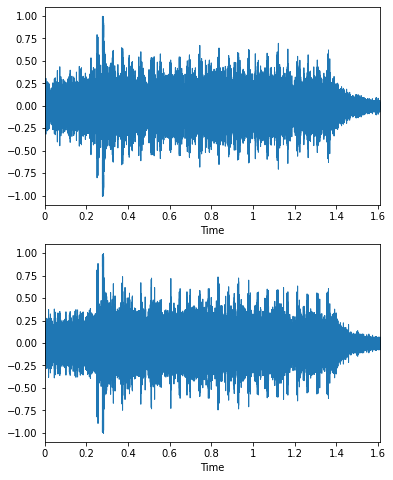

In [0]:
# Audio playback and audio-wave plot is supported by fastai2_audio
# This wave file includes 2 distinct signals which overlap, I have no idea how to handle this but this will
# create problems in tensor size during batching. I'll average the information and listen if it sounds
# similar to the original audio.

x.show()

In [0]:
# Merging the two signals still creates an audibly similar file and removes tensor mismatch
# issues for later.

y = x.mean(dim=0).reshape(1,-1)

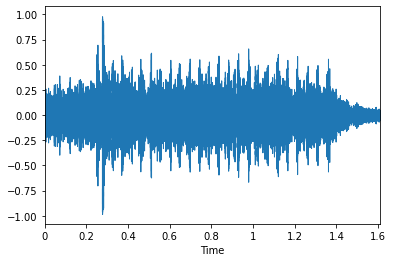

In [0]:
y.show()

In [0]:
y.shape

torch.Size([1, 192000])

In [0]:
# Trying to create audio signal crop transform based on bitrate

z = y[:,44100:44100+(44100*1)]

In [0]:
# Cropping seems to work fine

z.shape

torch.Size([1, 26794])

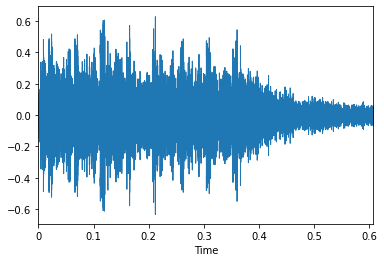

In [0]:
z.show()

In [0]:
def mergeSignal(x:AudioTensor)->AudioTensor:
  "Merges the input AudioTensor along the first dimension"
  return x.mean(dim=0).reshape(1,-1)

In [0]:
# SpectrogramTransformer class is provided by fastai2_audio and binds nicely with fastai learner
# API as per the documentation.

DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

# Using the constants from Dessa's Repo, more information in README
aud2spec = DBMelSpec(n_mels=240, f_min=50, f_max=8000, n_fft=1000, hop_length=200, top_db=100, sample_rate=16000, win_length=800)
#tfms = [AudioTensor.contiguous, CropSignal(4000, pad_mode='Zeros_After'), aud2spec, MaskTime(size=4), MaskFreq(size=10)]

In [0]:
aud2spec.settings

{'f_max': 8000,
 'f_min': 50,
 'hop_length': 200,
 'mel': True,
 'n_fft': 1000,
 'n_mels': 240,
 'pad': 0,
 'sample_rate': 16000,
 'stype': 'power',
 'to_db': True,
 'top_db': 100,
 'win_length': 800,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None}

In [0]:
# My crop method is not needed, this does the same thing and provides different kinds of padding.
# Using only 1 sec crops to get the model working, will iterate with different length later.

crop = CropSignal(1000, pad_mode='repeat')

In [0]:
# Testing the pipeline on sample files to check for spectogram details and dimension analysis.
# Update: This worked in the 7th attempt after fixing the sampling rate, more info in README.

pipe = Pipeline([AudioTensor.create , mergeSignal, RemoveSilence(), crop, aud2spec])

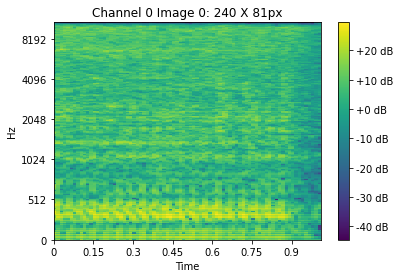

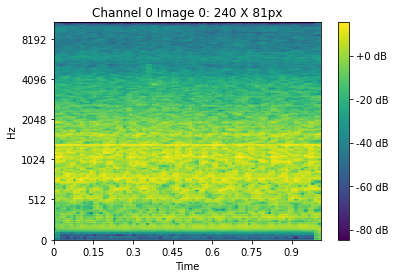

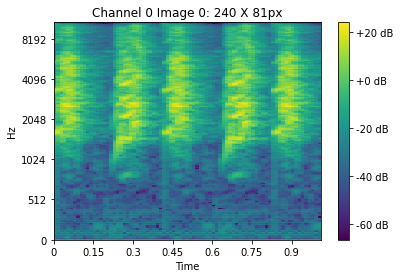

In [0]:
for fn in fnames:
  pipe(fn).show()

In [0]:
# Using the above pipeline as the transforms for the DataBlock API

tfms = [mergeSignal, RemoveSilence(), crop, aud2spec]

In [0]:
# Fastai2 DataBlock API, A detailed explanation is available in full_train.py

auds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = tfms,
                 get_y=lambda x: str(x).split('-')[1][0])

In [0]:
# Create a databunch with dataloader support and batch-size of 128. Only using data1 folder (10% data)

dbunch = auds.dataloaders(data, item_tfms = tfms, bs=128)

In [0]:
# Creating the learner object with CrossEntropyLoss and xresnet18 as stem-model.
# Update: We can only use Flattened version of loss_func because fastai2 needs an activation and decode
# method to support callbacks and transforms.

learn = Learner(dbunch, 
                xresnet18(),
                CrossEntropyLossFlat(), 
                metrics=[accuracy])

In [0]:
# Audio files are transformed to single channel spectoram images, fixing the learner object

def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [0]:
nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

(0.06309573650360108, 0.0020892962347716093)

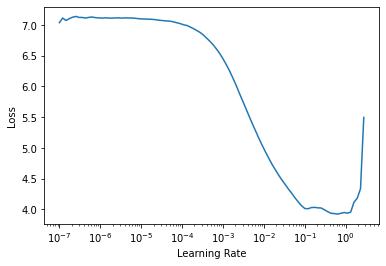

In [0]:
learn.lr_find()

In [0]:
# Fitting with one-cycle policy

learn.fit_one_cycle(10, lr_max=slice(5e-2))

epoch,train_loss,valid_loss,accuracy,time
0,2.592448,8.621713,0.057471,01:32
1,2.194343,272.377563,0.114943,01:33
2,2.347925,1960.637207,0.103448,01:32
3,2.303246,130.847000,0.091954,01:32
4,2.109400,31.240526,0.143678,01:32
5,1.937889,13.916354,0.103448,01:31
6,1.787991,5.294599,0.206897,01:32
7,1.653394,2.738235,0.385057,01:32
8,1.542035,1.278014,0.614943,01:31
9,1.450829,1.058588,0.649425,01:32


In [0]:
learn.fit_one_cycle(10, lr_max=slice(1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.888429,0.978081,0.689655,01:33
1,0.887373,1.112077,0.620690,01:32
2,0.860676,0.928193,0.689655,01:32
3,0.862433,1.179128,0.632184,01:31
4,0.849198,1.147771,0.643678,01:31
5,0.835092,0.919815,0.678161,01:31
6,0.808739,0.964900,0.672414,01:32
7,0.782946,0.930320,0.672414,01:32
8,0.758796,0.862723,0.712644,01:32
9,0.738966,0.787888,0.724138,01:31


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, lr_max=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.620501,0.781122,0.724138,01:32
1,0.636451,0.715135,0.781609,01:32
2,0.616415,0.745101,0.775862,01:32
3,0.608021,0.728937,0.775862,01:31
4,0.604026,0.685928,0.781609,01:31
5,0.606302,0.676430,0.787356,01:31
6,0.596624,0.658725,0.793103,01:31
7,0.588942,0.677584,0.764368,01:31
8,0.578663,0.684147,0.764368,01:31
9,0.574676,0.601150,0.798851,01:31


In [0]:
mname = 'baseline'
learn.save(mname)

In [0]:
# Adding Frequency and Time masks, more details in README

tfms = [mergeSignal, RemoveSilence(), crop, aud2spec, MaskTime(size=5), MaskFreq(size=5)]

In [0]:
ds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = tfms,
                 get_y=lambda x: str(x).split('-')[1][0])

In [0]:
dbunch = ds.dataloaders(data, bs=128)

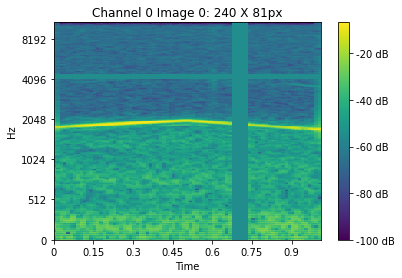

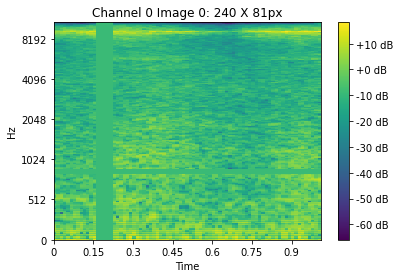

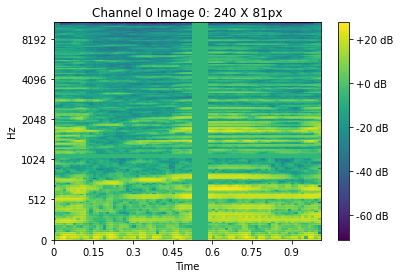

8
4
9


In [0]:
# Masks work fine

dbunch.show_batch(max_n=3)

In [0]:
# Writing an adaptible version for alter learner, for single channel images it will change the
# learner object or otherwise it remains the same. It will help when we use MFCC with 3-channel images. 

def audio_learner(dls, arch, loss_func, metrics):
  "Prepares a `Learner` for audio processing"
  def _alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))
  learn = Learner(dls, arch, loss_func, metrics=metrics)
  n_c = dls.one_batch()[0].shape[1]
  if n_c == 1: _alter_learner(learn)
  return learn

In [0]:
learn = audio_learner(dbunch, xresnet18(), CrossEntropyLossFlat(), accuracy)

(0.07585775852203369, 0.00363078061491251)

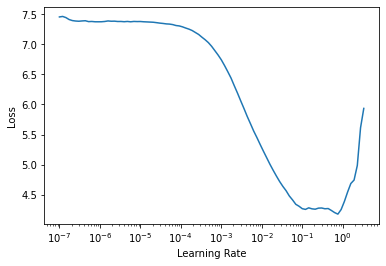

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.377301,7.981977,0.109195,01:34
1,4.376265,10.033366,0.022989,01:34
2,3.304700,8.692437,0.120690,01:35
3,2.719546,9.945577,0.137931,01:33
4,2.328439,6.511787,0.091954,01:33
5,2.042378,3.921779,0.195402,01:32
6,1.816211,1.401714,0.568965,01:34
7,1.630415,1.117402,0.660920,01:34
8,1.480907,0.759777,0.747126,01:32
9,1.357353,0.687261,0.787356,01:32


In [0]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.684712,0.640260,0.804598,01:33
1,0.642547,0.675264,0.793103,01:32
2,0.636901,0.622171,0.810345,01:32
3,0.631993,0.676245,0.775862,01:32
4,0.625365,0.659127,0.804598,01:33
5,0.616016,0.655681,0.775862,01:32
6,0.597299,0.585297,0.816092,01:33
7,0.585462,0.584558,0.816092,01:33
8,0.574908,0.552879,0.839080,01:32
9,0.569285,0.574420,0.816092,01:33


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10, lr_max=slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.527326,0.552866,0.839080,01:33
1,0.543912,0.535282,0.844828,01:33
2,0.526712,0.571776,0.816092,01:32
3,0.524578,0.528549,0.862069,01:32
4,0.524017,0.553406,0.833333,01:32
5,0.521907,0.542949,0.850575,01:32
6,0.516026,0.535284,0.839080,01:32
7,0.510873,0.575348,0.821839,01:32
8,0.506707,0.545101,0.850575,01:32
9,0.504674,0.532182,0.844828,01:32


In [0]:
mname = 'medium'
learn.save(mname)

In [0]:
# AudioToMFCC is supported by fastai2_audio, addiotionally supports Delta() method for channel-shifts.

aud2mfcc = AudioToMFCC(n_mfcc=32, melkwargs={'n_fft':1000, 'hop_length':200, 'n_mels':240})

In [0]:
# Trying RemoveSilence transform, will test is the performance improves without it and remove.

tfms = [mergeSignal, RemoveSilence(), crop, aud2mfcc]

In [0]:
ds.item_tfms = tfms

In [0]:
dbunch = ds.dataloaders(data, bs=128)

In [0]:
learn = audio_learner(dbunch, xresnet18(), CrossEntropyLossFlat(), accuracy)

(0.012022644281387329, 0.0020892962347716093)

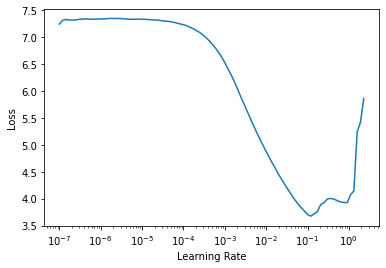

In [327]:
learn.lr_find()

In [328]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.060681,4.322249,0.160920,00:19
1,3.772932,3.141375,0.212644,00:19
2,2.645681,7.878147,0.195402,00:19
3,2.020354,2.980537,0.396552,00:19
4,1.619904,1.751046,0.568965,00:19
5,1.328254,0.642929,0.781609,00:19
6,1.113378,0.384808,0.885057,00:19
7,0.945080,0.360972,0.879310,00:19
8,0.807906,0.223545,0.954023,00:19
9,0.701126,0.182778,0.948276,00:19


In [0]:
# Trying the exact same thing with a larger MFCC window to increase image details. Changing to
# 2 sec audio crop, 1 and 3 sec performs poor.

aud2mfcc = AudioToMFCC(n_mfcc=64, melkwargs={'n_fft':1000, 'hop_length':200, 'n_mels':240})
crop = CropSignal(2000, pad_mode='repeat')
tfms = [mergeSignal, crop, aud2mfcc, Delta()]

In [0]:
ds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = tfms,
                 get_y=lambda x: str(x).split('-')[1][0])

In [0]:
dbunch = ds.dataloaders(data, bs=128)

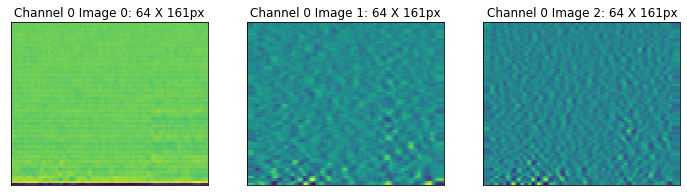

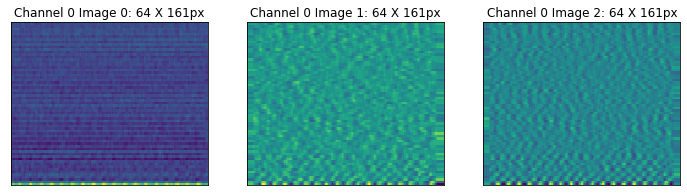

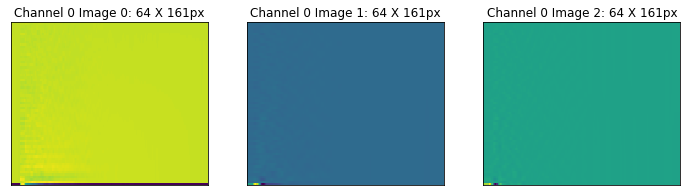

3
7
6


In [16]:
dbunch.show_batch(max_n=3)

In [0]:
learn = audio_learner(dbunch, xresnet18(), CrossEntropyLossFlat(), accuracy)

(0.014454397559165954, 0.0030199517495930195)

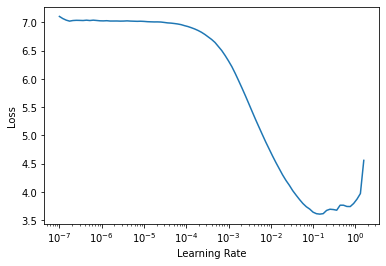

In [21]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.434410,5.416224,0.218391,00:49
1,4.014361,2.206848,0.316092,00:49
2,2.788188,1.444286,0.586207,00:48
3,2.089891,1.282277,0.597701,00:48
4,1.649626,0.727451,0.775862,00:48
5,1.341895,0.855450,0.729885,00:48
6,1.113692,0.167395,0.948276,00:48
7,0.935348,0.129403,0.959770,00:48
8,0.797306,0.090649,0.971264,00:48
9,0.685802,0.104676,0.965517,00:48


In [0]:
learn.unfreeze()

In [24]:
# Since we are getting almost 97% accuracy with 10% data on 80/20 split. Let's overfit and test on an unseen
# data folder to estimate the effect of class distribution.

learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.062263,0.070793,0.982759,00:48
1,0.058587,0.101534,0.977012,00:48
2,0.051525,0.080927,0.977012,00:48
3,0.045310,0.047624,0.988506,00:48
4,0.039939,0.048090,0.988506,00:49
5,0.034796,0.026011,1.000000,00:48
6,0.031214,0.030176,0.994253,00:49
7,0.028409,0.037094,0.988506,00:49
8,0.025470,0.034025,0.994253,00:48
9,0.023536,0.021357,1.000000,00:48


In [0]:
mname = 'strong'
learn.save(mname)

In [26]:
fnames

[Path('data1/357-7.wav'), Path('data1/457-5.wav'), Path('data1/446-3.wav')]

In [28]:
[learn.predict(x)[0] for x in fnames]

['7', '5', '3']

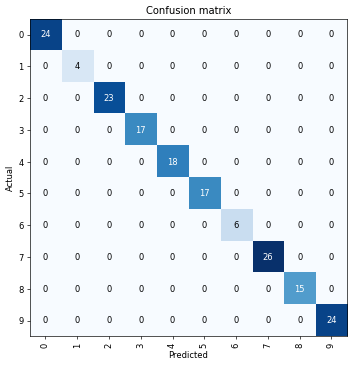

In [34]:
# Everything on point, extremely overfit

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [0]:
# Adding a new folder `data2` to dataloader and testing the model accuracy on 20% random sample. 

learn.dls = ds.dataloaders(Path('data2'), bs=128)

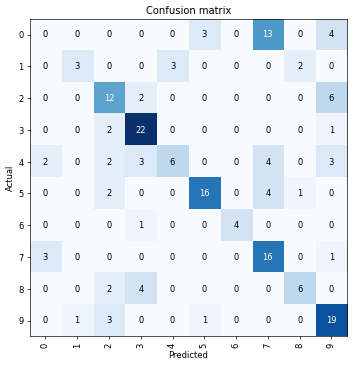

In [37]:
# Class 0 and Class 2 are most confused wth Class 7 and Class 9 respectively.

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [38]:
interp.most_confused(min_val=5)

[('0', '7', 13), ('2', '9', 6)]

In [0]:
# Stupid me, showed have extracted these folders under `Data` folder at the very begining.
! mkdir Data
! mv -t Data data1 data2 data3 data4 data5 data6 data7 data8 data9 data10

In [0]:
# Using full data to fine-tune the model.

learn.dls = ds.dataloaders(Path('Data'), bs=128)

In [42]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.716889,1.229295,0.661512,08:24
1,0.991293,0.637471,0.795533,08:13
2,0.648710,0.510288,0.827033,08:11
3,0.462121,0.380597,0.882016,08:07
4,0.328804,0.343329,0.881443,08:16
5,0.234446,0.266029,0.909507,08:24
6,0.178295,0.242098,0.924971,08:18
7,0.134211,0.201166,0.932417,08:21
8,0.101667,0.181283,0.941581,08:25
9,0.084325,0.182074,0.939290,08:20


In [43]:
learn.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.074549,0.174415,0.946163,08:17
1,0.075718,0.176441,0.943299,08:17
2,0.073676,0.166143,0.948454,08:15
3,0.067013,0.164337,0.948454,08:14
4,0.064114,0.167674,0.946163,08:14


In [47]:
# Using discriminative learning rate to differentially train parts of the network at very low LR

learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.059786,0.170072,0.946735,07:58
1,0.064741,0.160861,0.949599,07:59
2,0.062301,0.177342,0.938717,08:04
3,0.062866,0.145910,0.955326,07:56
4,0.059540,0.150552,0.953608,07:57
5,0.053957,0.149639,0.949599,08:00
6,0.050048,0.148834,0.949026,08:12
7,0.045525,0.160862,0.955899,08:07
8,0.043328,0.157730,0.951890,07:56
9,0.038964,0.150946,0.954754,08:09


In [0]:
learn.save('bestConfigFullData')

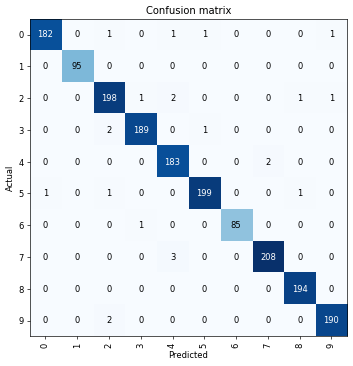

In [83]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [85]:
# Only one example of a class misclassifying 3 or more audio files. 95% accuracy seems legit.

interp.most_confused(min_val=3)

[('7', '4', 3)]

### Creating the prediction patch for inference mode

In [0]:
aud2mfcc = AudioToMFCC(n_mfcc=64, melkwargs={'n_fft':1000, 'hop_length':200, 'n_mels':240})
crop = CropSignal(2000, pad_mode='repeat')
tfms = [mergeSignal, crop, aud2mfcc, Delta()]

ds = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 item_tfms = tfms)

dbunch = ds.dataloaders(data, bs=1)

learn = audio_learner(dbunch, xresnet18(), CrossEntropyLossFlat(), accuracy)

In [92]:
learn.load('bestConfigFullData')

In [99]:
samples = list(Path('Data/data4/').iterdir())[:5];samples

[Path('Data/data4/964-8.wav'),
 Path('Data/data4/239-9.wav'),
 Path('Data/data4/55-0.wav'),
 Path('Data/data4/443-5.wav'),
 Path('Data/data4/554-0.wav')]

In [106]:
# Predictions look good!

[(str(x), learn.predict(x)[1]) for x in samples]

[('Data/data4/964-8.wav', tensor(8)),
 ('Data/data4/239-9.wav', tensor(9)),
 ('Data/data4/55-0.wav', tensor(0)),
 ('Data/data4/443-5.wav', tensor(5)),
 ('Data/data4/554-0.wav', tensor(0))]